In [13]:
import xarray as xr

# Load datasets
ds_topo = xr.open_dataset('/Users/epauthen/Documents/Database/GEBCO_03_Dec_2025_25b803d83112/gebco_2025_n46.5_s42.5_w4.5_e8.5.nc')
ds_mask = xr.open_dataset('/Users/epauthen/Documents/GitHub/Hackathon-Meteo-France/Alpes_grid.nc')

# Reproject or interpolate topography to match ds_mask grid (assuming mask uses coordinates 'x' and 'y')
# If ds_mask's lat/lon are named "lat" and "lon", match those. Adjust variable names if needed.
ds_topo_on_mask = ds_topo.interp(
    lat=ds_mask['lat'], 
    lon=ds_mask['lon'], 
    method="nearest"
)
ds_topo_on_mask.to_netcdf('/Users/epauthen/Documents/GitHub/Hackathon-Meteo-France/Alpes_grid_ESM2.nc')


In [64]:
import xarray as xr
import numpy as np
import glob

# Load temperature data
input_pattern = '/Users/epauthen/Documents/Database/Hackaton_MeteoFrance/tas/tasAdjust_alpes_day_*.nc'
input_files = sorted(glob.glob(input_pattern))
ds = xr.open_mfdataset(input_files, decode_times=False)
temp = ds['tasAdjust']

# Load topography
ds_topo = xr.open_dataset('/Users/epauthen/Documents/GitHub/Hackathon-Meteo-France/Alpes_grid_ESM2.nc')
elevation = ds_topo['elevation']

# Ensure time is decoded correctly
if not np.issubdtype(temp['time'].dtype, np.datetime64):
    times = xr.decode_cf(ds)['time']
else:
    times = temp['time']

# Create a selector for DJF (December, January, February)
# We'll use .dt.month between 12 and 2 (spanning next year for DJF). This only works with datetime64.
# First, get indices of DJF months
month = xr.DataArray(times.dt.month.values, dims='time')
is_djf = (month == 12) | (month == 1) | (month == 2)

# Select only DJF data for temp and time
temp_djf = temp.isel(time=is_djf)
times_djf = times[is_djf]

# Make sure elevation is broadcast if needed; not necessary but safe
# Define freezing threshold and buffer
freezing_threshold = 273.15
buffer = 0.5

# Create mask for each day: True where temperature is near freezing
freezing_mask = (temp_djf >= (freezing_threshold - buffer)) & (temp_djf <= (freezing_threshold + buffer))

# Get elevation at freezing points for each DJF day (keeps time dimension)
elevation_freezing = elevation.where(freezing_mask)

# Calculate daily statistics for DJF only
daily_stats_djf = xr.Dataset({
    'mean_elevation': elevation_freezing.mean(dim=['y', 'x'], skipna=True),
    'max_elevation': elevation_freezing.max(dim=['y', 'x'], skipna=True),
    'min_elevation': elevation_freezing.min(dim=['y', 'x'], skipna=True),
    'median_elevation': elevation_freezing.median(dim=['y', 'x'], skipna=True),
    'count_points': freezing_mask.sum(dim=['y', 'x'])  # Number of grid points at freezing
})
# Attach the correct DJF times as the new time coordinate
daily_stats_djf = daily_stats_djf.assign_coords(time=times_djf)

# Add attributes
daily_stats_djf['mean_elevation'].attrs['long_name'] = 'Mean elevation of 0°C isotherm (DJF only)'
daily_stats_djf['mean_elevation'].attrs['units'] = 'm'

# Save results
daily_stats_djf.to_netcdf('isotherme_0_daily_altitude_DJF.nc')

In [68]:
daily_stats = xr.open_dataset('isotherme_0_daily_altitude_DJF.nc')
# Define the periods as tuples of (start, end)
periods = [
    ('1990-2020', '1990-01-01', '2020-12-31'),
    ('2021-2040', '2021-01-01', '2040-12-31'),
    ('2041-2060', '2041-01-01', '2060-12-31'),
    ('2061-2080', '2061-01-01', '2080-12-31'),
    ('2081-2100', '2081-01-01', '2100-12-31'),
]

# Ensure 'time' coordinate is decoded as datetime
if not np.issubdtype(daily_stats['time'].dtype, np.datetime64):
    daily_stats['time'] = xr.decode_cf(daily_stats).time

averaged_stats = {}
for label, start, end in periods:
    # Slice the dataset for the given period
    period_data = daily_stats.sel(time=slice(start, end))
    # Average over the time dimension for all variables
    mean_data = period_data.mean(dim='time', skipna=True)
    # Convert to regular dict for neat printing/output
    averaged_stats[label] = {var: float(mean_data[var].values) for var in mean_data.data_vars}

# Display the result
import pandas as pd
df = pd.DataFrame(averaged_stats).T
df.to_csv('isotherme_0_averaged_stats.csv')
display(df)


,mean_elevation,max_elevation,min_elevation,median_elevation,count_points
1990-2020,1400.132119,2498.034310,619.758041,1373.663152,499.424589
2021-2040,1541.624749,2650.134626,716.697507,1515.038504,483.665928
2041-2060,1562.187016,2689.736696,710.817627,1539.114191,468.700831
2061-2080,1736.144180,2841.766741,888.143415,1711.551897,418.510249
2081-2100,1916.969124,2997.059088,1043.234102,1897.398143,366.274390


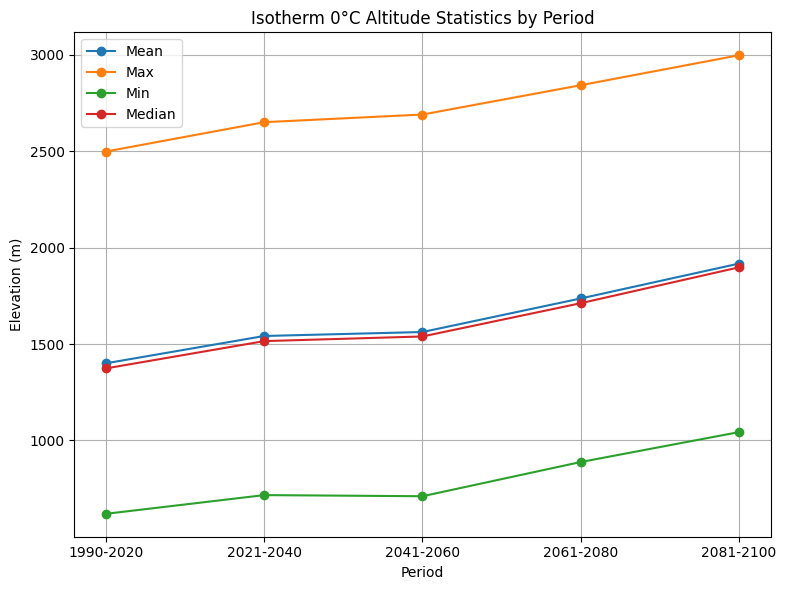

In [69]:
import matplotlib.pyplot as plt

# List the four variables to put on the same plot
vars_to_plot = ['mean_elevation', 'max_elevation', 'min_elevation', 'median_elevation']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ['Mean', 'Max', 'Min', 'Median']

fig, ax = plt.subplots(figsize=(8, 6))

for var, color, label in zip(vars_to_plot, colors, labels):
    ax.plot(df.index, df[var], marker='o', label=label, color=color)

ax.set_xlabel('Period')
ax.set_ylabel('Elevation (m)')
ax.set_title('Isotherm 0°C Altitude Statistics by Period')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
